# Data Reprocessing Alignment Studies
This notebook contains plots showing the effect of the unset dynamic alignment flag on the recent reprocessing of DAOD_RPVLL data. More information can be found at the reprocessing JIRA ticket https://its.cern.ch/jira/browse/DATREP-183 and the LLP Forum meeting https://indico.cern.ch/event/933994/.

In [301]:
# Signal Efficiency Plotting Script
import argparse, os, math, ROOT, glob, uproot, time
import numpy as np
import matplotlib.pyplot as plt
import random, string
from IPython.display import Image

from ROOT import gROOT
# from pylab import *
gROOT.SetStyle("ATLAS");


def ATLASLabel(x, y, text=None, color=1):
    l = ROOT.TLatex()
    l.SetNDC()
    l.SetTextColor(color)
    l.DrawLatex(x, y, r"#bf{#it{ATLAS}}" + text)


def draw_text(*args, pos=(.5, .85)):
    x, y = pos

    ATLASLabel(x, y, "Internal")
    y = y - .05

    for text in args:
        # get latex note
        n = ROOT.TLatex()
        n.SetNDC()
        n.SetTextFont(43)
        n.SetTextColor(1)
        n.SetTextSize(30)
        n.DrawLatex(x, y, text)
        y = y - .05

def parse_sample(sample):
    sample_dict = {}
    tokens = sample.split('_')
    for token in tokens:
        if token == "WmuHNL50": sample_dict['prompt_lepton'] = 'mu'
        if token == "WelHNL50": sample_dict['prompt_lepton'] = 'el'
        if token == "5G": sample_dict['mass'] = '5 GeV'
        if token == "10G": sample_dict['mass'] = '10 GeV'
        if token == "20G": sample_dict['mass'] = '20 GeV'
        if token == "lt1dd": sample_dict['lifetime'] = '1 mm'
        if token == "lt10dd": sample_dict['lifetime'] = '10 mm'
        if token == "lt100dd": sample_dict['lifetime'] = '100 mm'
        if token == "ee": sample_dict['dv'] = 'e-e'
        if token == "emu": sample_dict['dv'] = 'e-mu'
        if token == "el": sample_dict['dv'] = 'e-mu'
    if 'dv' not in sample_dict: sample_dict['dv'] = 'mu-mu'
    return (sample_dict)


def make_cutflow_dict(hcutflow):
    cutflow_dict = {}
    for i in range(hcutflow.GetXaxis().GetNbins()):
        try:
            label = str(hcutflow.GetXaxis().GetLabels()[i])
#             if "filter" in label: label = "filter mismatch"
        except:
            continue
            label = "no cut"
        value = hcutflow[i + 1]
        cutflow_dict[label] = value
    return cutflow_dict




def print_cutflow_to_file(cutflow_dict_tp, cutflow_dict_fp, output_file, name=""):
    # Print cutflows to text file
    with open(output_file, 'w') as f:
        # Print title
        print("cut".rjust(20), "True Positive".rjust(15), "False Positive".rjust(15), "Scale Factor".rjust(15), sep
              =" -", file=f)
        print("                 ------------------------------------------------------", file=f)
        # Print table
        for key in cutflow_dict_tp.keys():
            val_tp = cutflow_dict_tp[key]
            val_fp = cutflow_dict_fp[key]
            try: scale_factor = val_tp / (val_fp + val_tp)
            except: print("sounds like you tried to divide by zero")
            if key in ["all", "trigger"]: scale_factor = 1  # don't show scale factor before filter cut
            print(
                key.rjust(20), str(val_tp).rjust(15), str(val_fp).rjust(15), "{0:.4f}".format(scale_factor).rjust(15),
                sep
                ="  ", file=f)


def make_cutflow(ch_name='VSI', color=ROOT.kAzure, histogram_path="", labels=[], output_file=""):
    # Open file and get cutflow
    tfile = ROOT.TFile(histogram_path)

    hcutflow = tfile.Get(f'{ch_name}/CutFlow/CutFlow_{ch_name}')
    # Create canvas
    # hcutflow.GetXaxis().SetBinLabel(3, ch_name)
    canvas_name = ''.join(random.choices(string.ascii_uppercase + string.digits, k=6))
    canvas = ROOT.TCanvas(canvas_name, "cutflow", 1000, 800)
    canvas.cd(1)

    # Prepare histogram settings for drawing
    ymax_cutflow = hcutflow.GetMaximum()
    hcutflow.GetYaxis().SetRangeUser(0, ymax_cutflow * 1.05)
    hcutflow.SetFillColor(color)
    hcutflow.SetLineWidth(0)
    hcutflow.GetXaxis().SetTickLength(0)
    hcutflow.SetMarkerSize(1.5)
    hcutflow.Draw("HIST TEXT0 SAME")

    # Add text information
    draw_text(*labels)

    # Display and save image
    # MyC02.Draw(canvas_name)
    canvas.SaveAs(output_file)
    # display(Image(output_file))

    return make_cutflow_dict(hcutflow)

def make_cutflows(hist_path_a, hist_path_b, ch_name='VSI', extra_labels=[]):

    # Make a plot directory alongside the histograms
    plot_dir = os.path.abspath(os.path.join(hist_path_a, os.pardir, "plots"))
    os.makedirs(plot_dir, exist_ok=True)
    
    # A rough check to automatically get the sample properties
    name = ""
    for token in hist_path_a.split("/"):
        if "user.rnewhous.data" in token :
            data_year = token.split('.')[2]
            if 'r11764' in token:
                alignment_status = 'Off'
                labels = ['Alignment off']
            elif 'r11784' in token:
                alignment_status = 'On'
                labels = ['Alignment on']

    # Get cutflows
    cutflow_dict_a = make_cutflow(ch_name=ch_name, color=ROOT.kAzure - 4, histogram_path=hist_path_a,
                                   labels=[*labels, ch_name], output_file=os.path.join(plot_dir, 'Cutflow_alignment_off.png'))
    cutflow_dict_b = make_cutflow(ch_name=ch_name, color=ROOT.kRed - 4, histogram_path=hist_path_b,
                                   labels=[*labels, ch_name], output_file=os.path.join(plot_dir, 'Cutflow_alignment_on.png'))

        
#     normalize_to_first_bin = True
#     if normalize_to_first_bin:
#         tmp_dict_b = {}
#         scale = cutflow_dict_b['all']/cutflow_dict_a['all']
#         for key in cutflow_dict_b.keys():
#             tmp_dict_b[key] = cutflow_dict_b[key]/scale
#         cutflow_dict_b = tmp_dict_b

        
    # Save a stacked cutflow to show comparison
    labels=[data_year, ch_name]
    plot_stacked_cutflow(cutflow_dict_a, cutflow_dict_b, os.path.join(plot_dir, 'Cutflow_diff.png'), [*labels, *extra_labels], name)

    
    
def plot_stacked_cutflow(cutflow_dict_a, cutflow_dict_b, output_file, labels=[], name=""):
    # Prepare inputs
    fig, ax1 = plt.subplots(figsize=(13, 8))
    ind = np.arange(len(cutflow_dict_a))
    vals_a = np.array(list(cutflow_dict_a.values()))
    vals_b = np.array(list(cutflow_dict_b.values()))
#     vals_b[0:2] = [0, 0]
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][0:2]  # get colors for labels later

    # Plot stacked cutflow
    p_a = ax1.bar(ind, vals_a, width=1, label="Filter alignment off", color=colors[0])  # plot bar graph
    p_b = ax1.step(np.append(-1, ind)+.5, np.append(vals_b[0], vals_b), 
                   label="Filter alignment on", linewidth=5, color=colors[1])  # plot bar graph
    plt.ylim((0, vals_a[0] * 1.2))
    plt.xticks(ind, cutflow_dict_a.keys(), rotation=60, ha='right', fontsize=15)
    plt.ylabel('Number of passed events', fontsize=20)
    ax1.legend(loc=(.65, .4), fontsize=20)

    # Print text labels on top of cutflow
    cmap = plt.cm.get_cmap('Oranges')
    for v, i in enumerate(ind):
        max_height = max(vals_a[i], vals_b[i])
        plt.text(i, max_height + 6000, "{:.0f}".format(vals_a[i]),
                 color=colors[0], fontweight='bold', fontsize=12, ha='center')
        diff = vals_b[i] - vals_a[i]
        if diff == 0: continue
        plt.text(i, max_height + 45000, "{:.0f}".format(vals_b[i]),
                 color=colors[1], fontweight='bold', fontsize=12, ha='center')
        text = "{:+.0f}".format(diff)
        text = "{:+.1f}%".format(-diff/vals_b[i]*100)
        plt.text(i, max_height + 25000, text,
                 color='red', fontweight='bold', fontsize=18, ha='center')

    # Print information on plot
    plt.text(.65, .75, "ATLAS", fontweight='bold', fontstyle='italic', fontsize=28, transform=ax1.transAxes)
    plt.text(.80, .75, "Internal", fontsize=28, transform=ax1.transAxes)
#     ax2.tick_params(axis='both', which='major', labelsize=15)
    ypos = 0.75
    for label in labels:
        plt.text(.35, ypos, label, fontsize=20, transform=ax1.transAxes)
        ypos = ypos - 0.075

    plt.title(name, fontsize=20)
    plt.tight_layout()
    plt.savefig(output_file)
    plt.show()


# Data 15
## Prompt mu/e, displaced mu/e channels.
## Loose and Medium selection on prompt lepton.

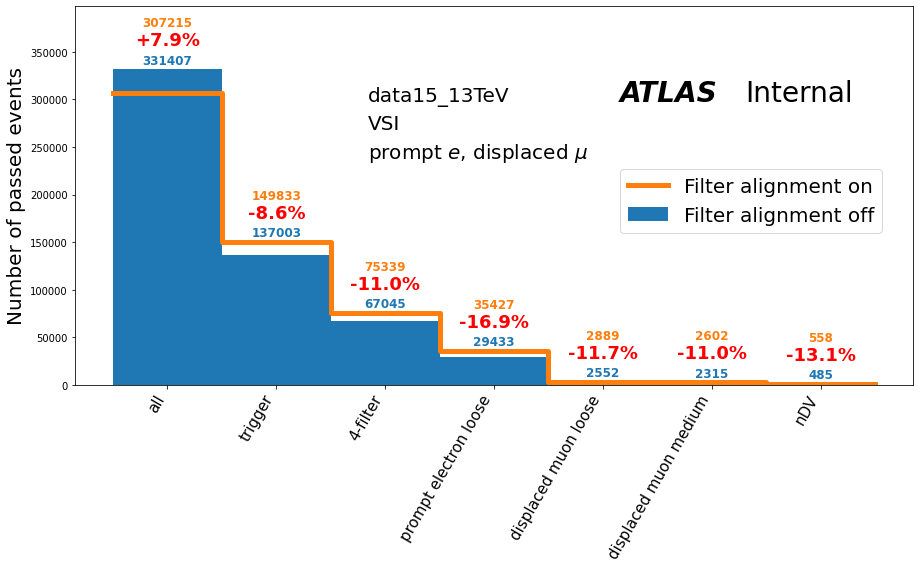

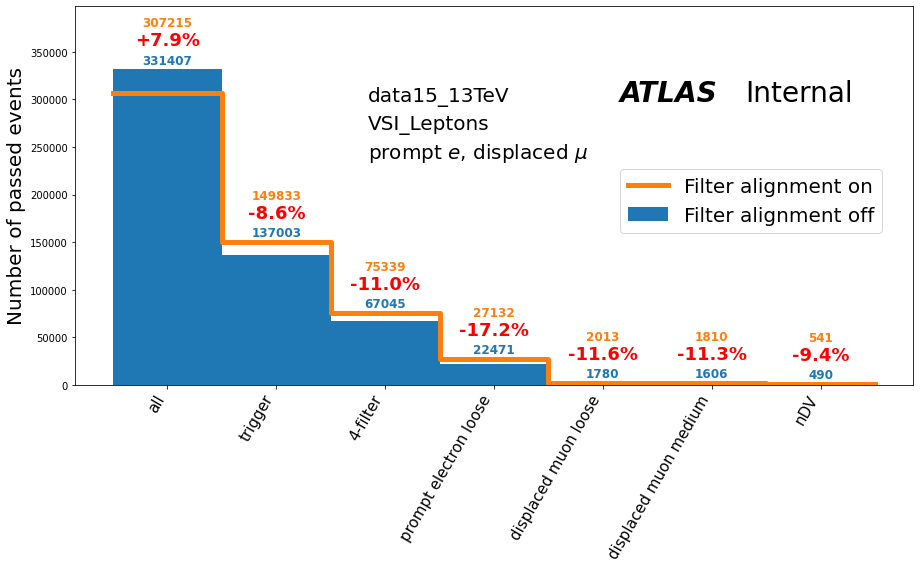

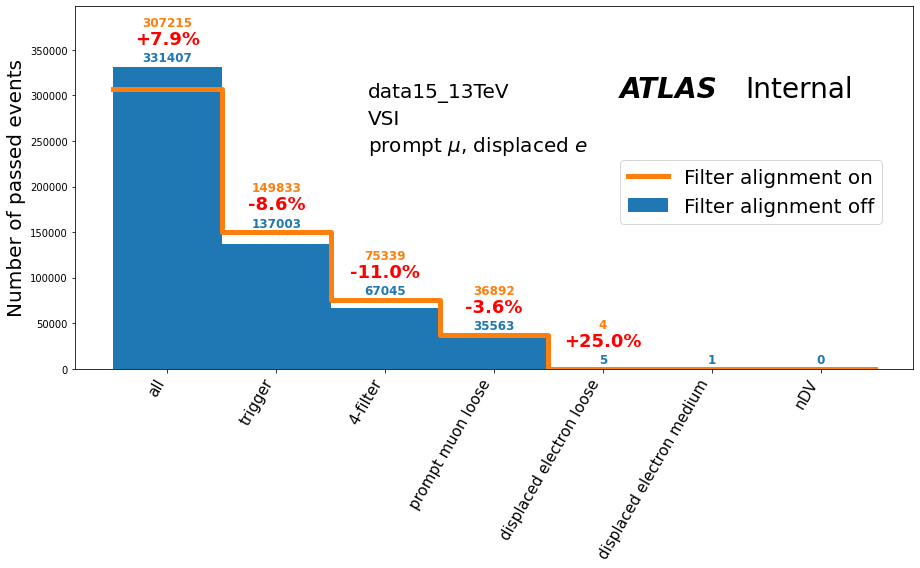

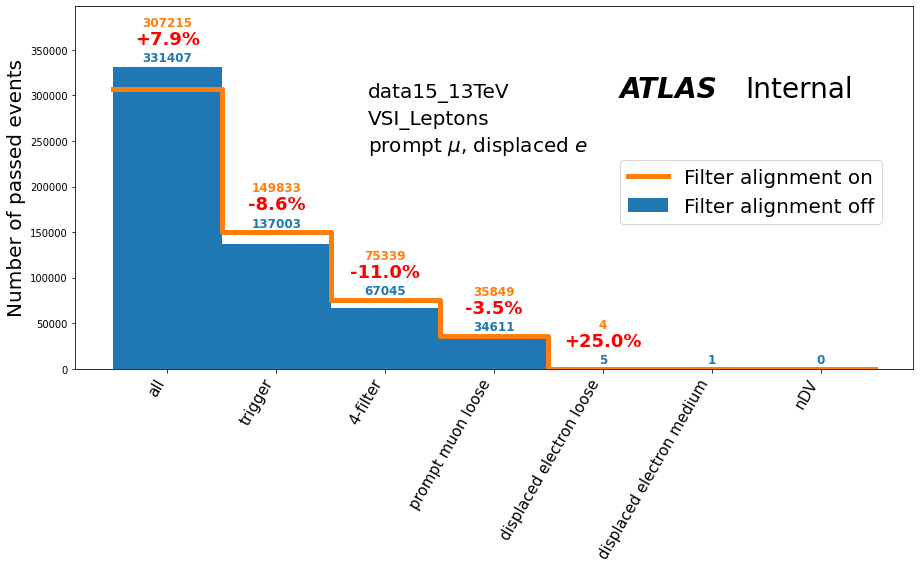

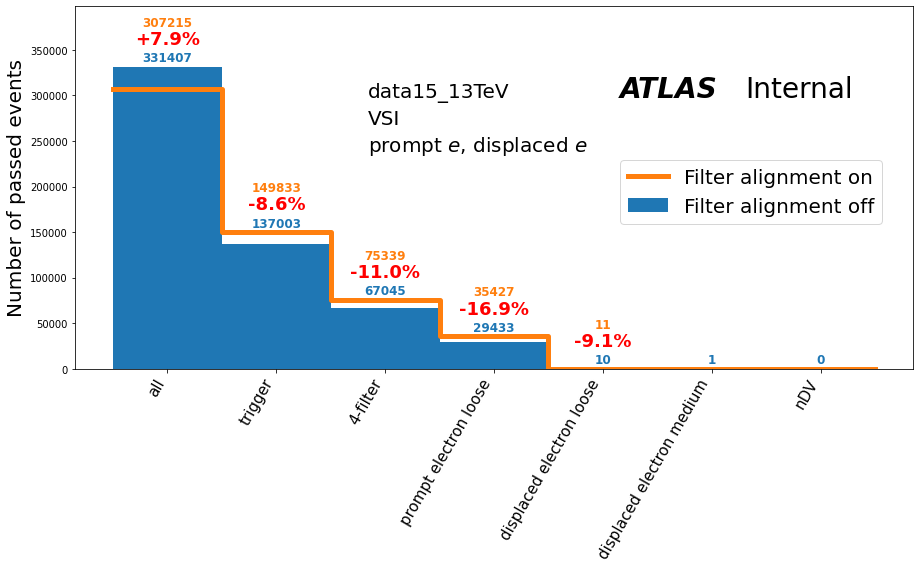

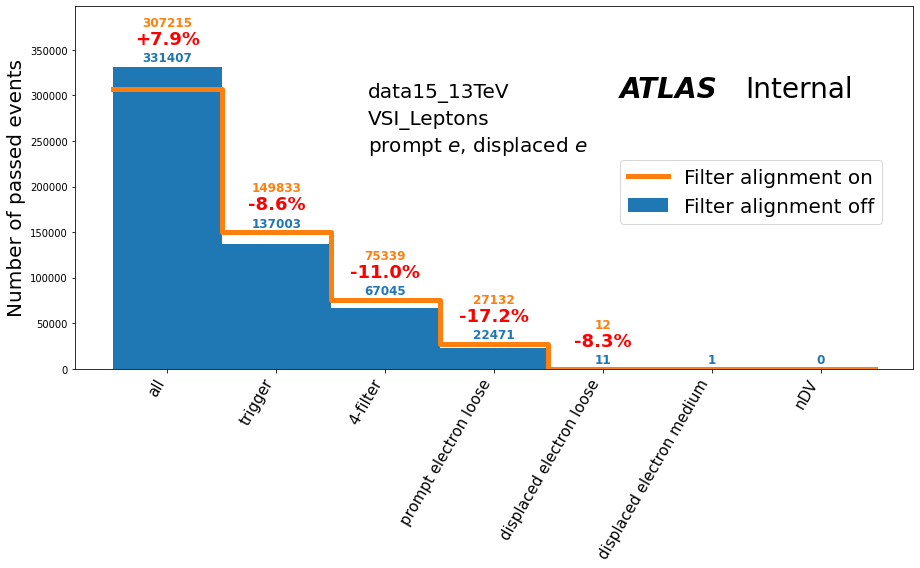

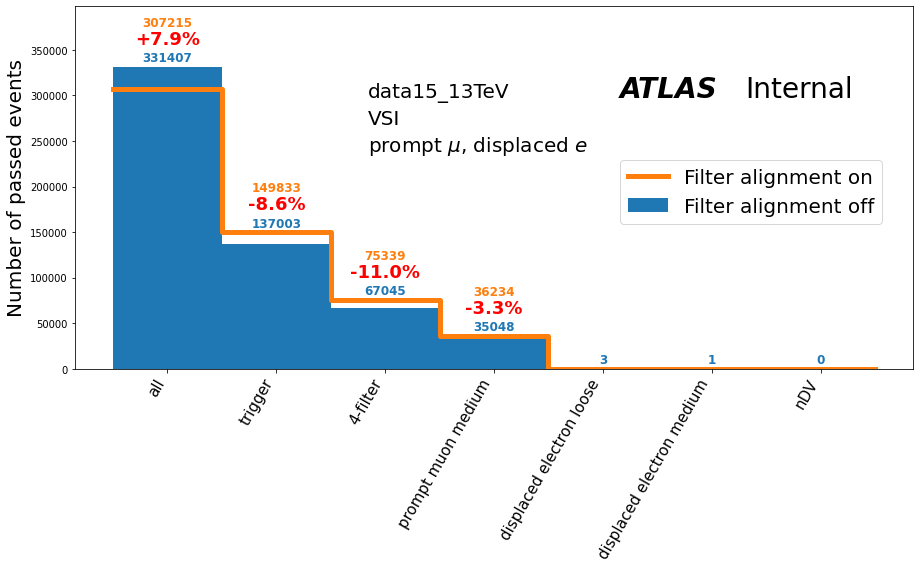

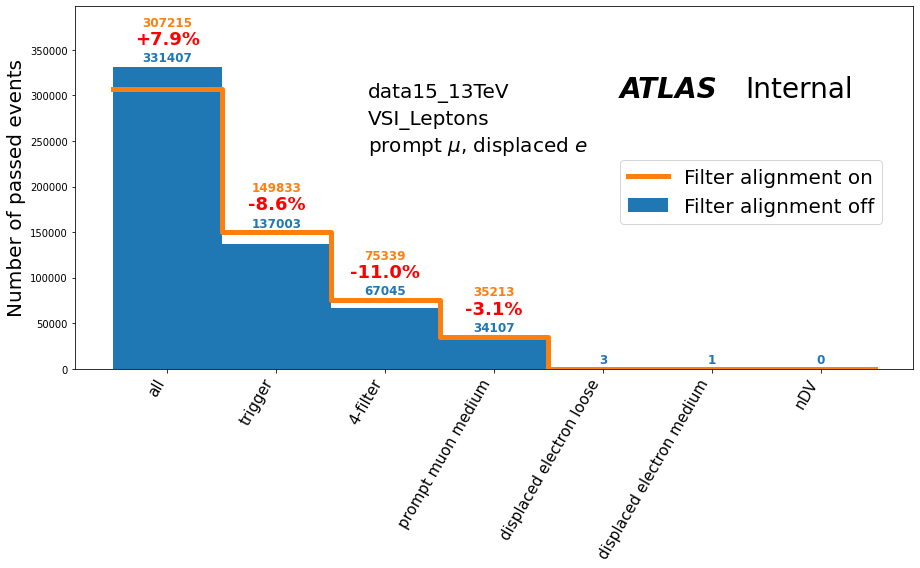

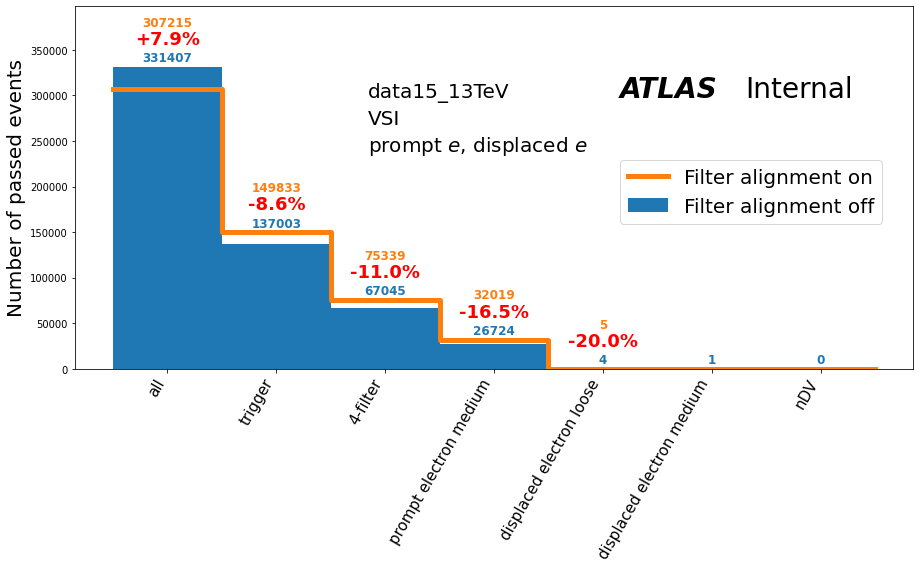

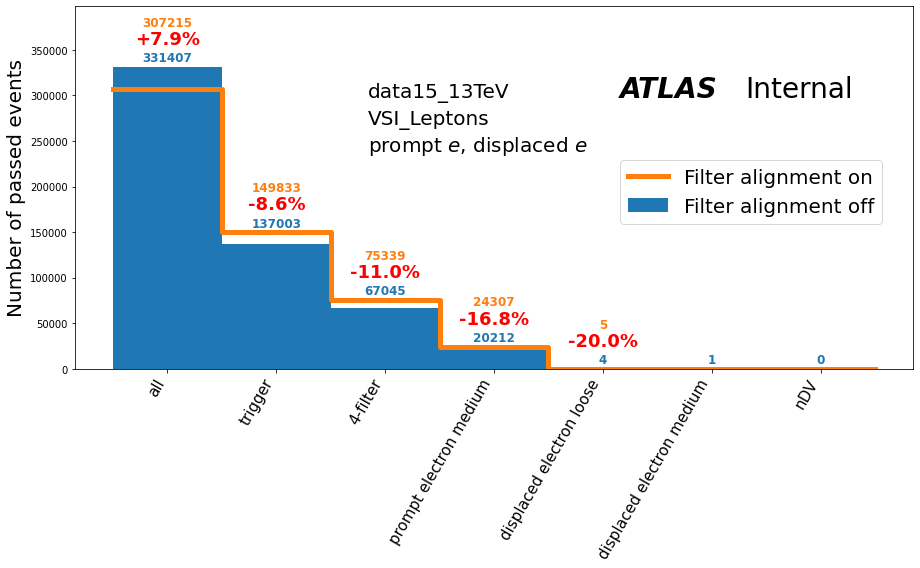

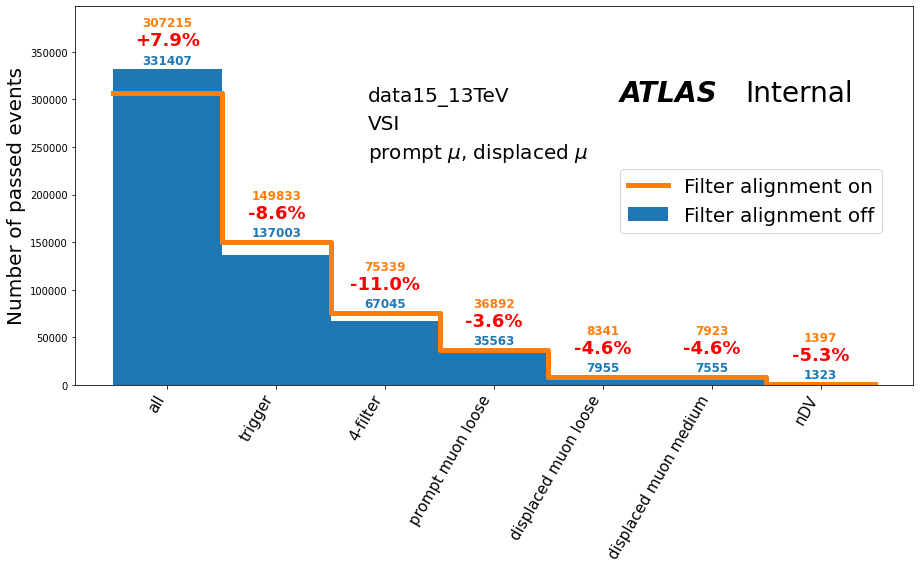

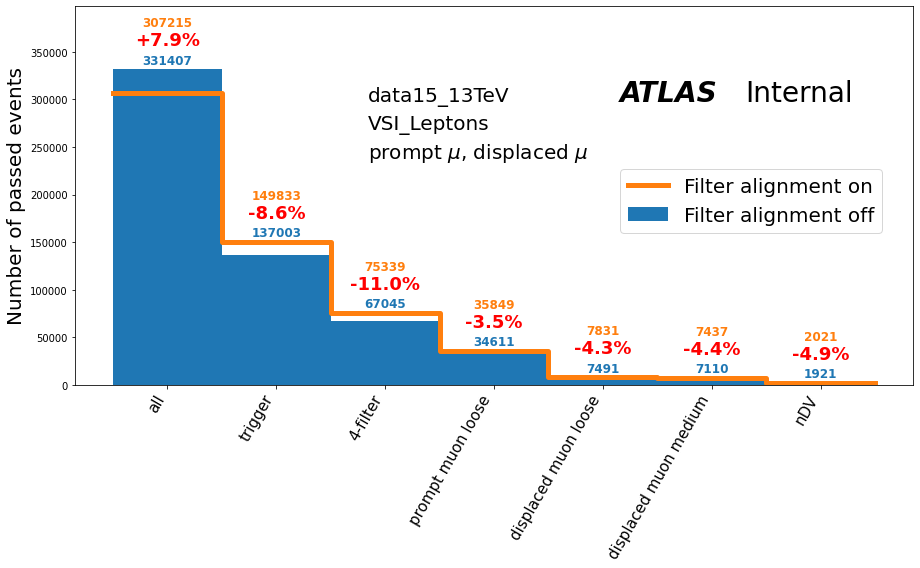

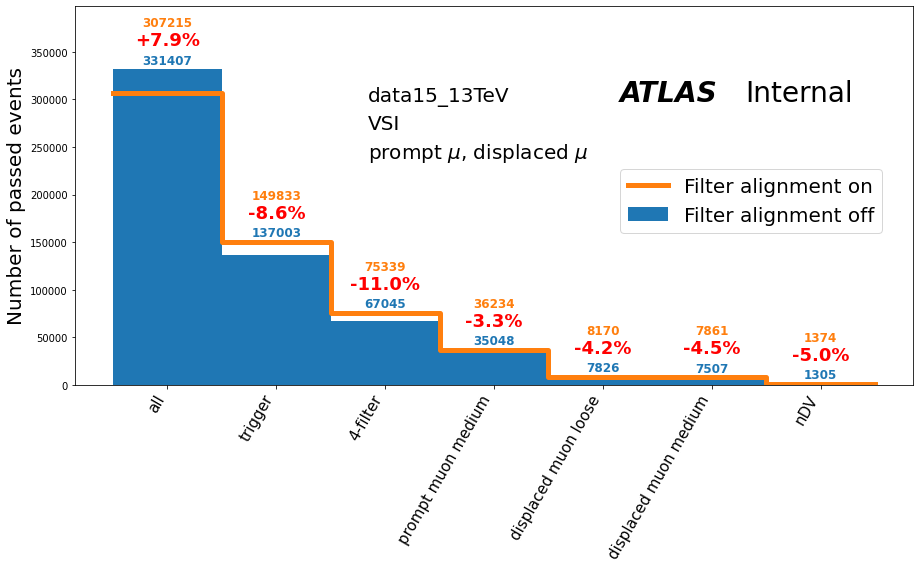

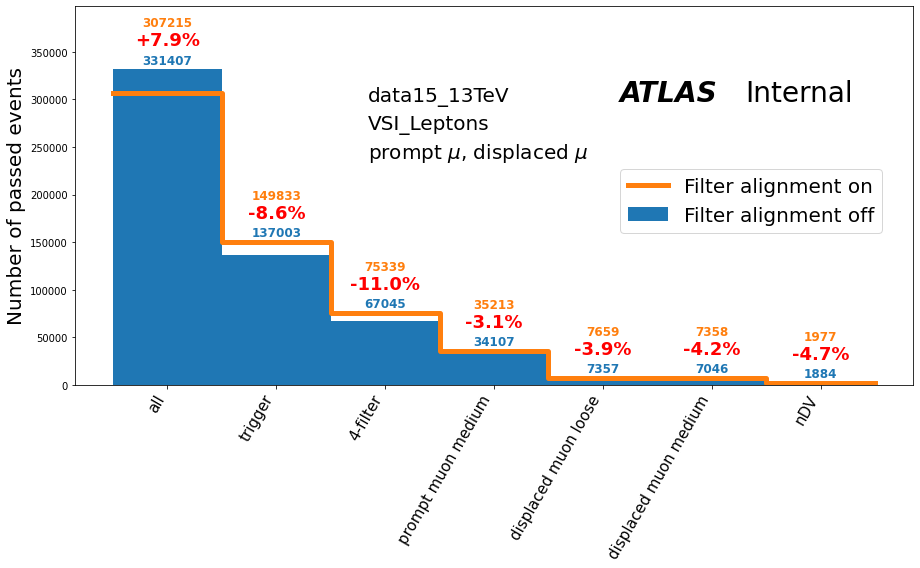

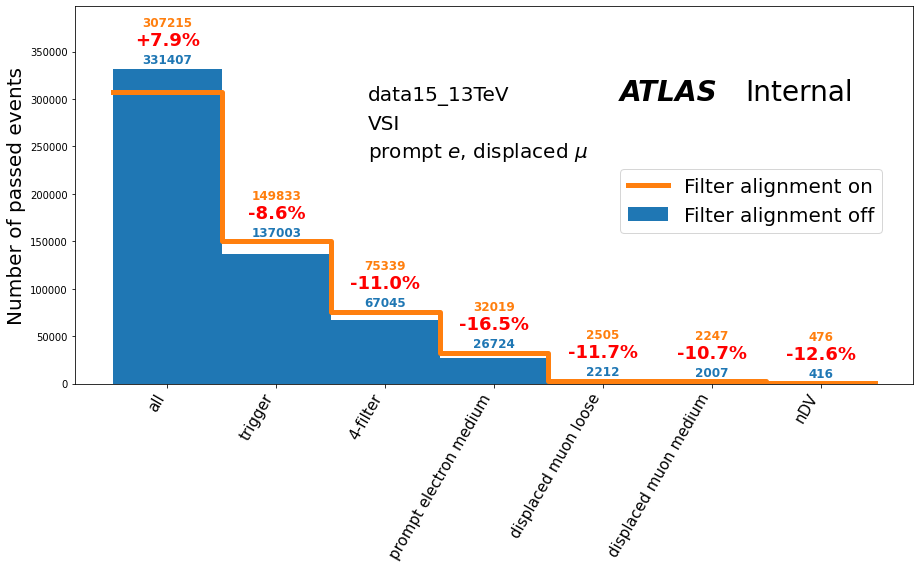

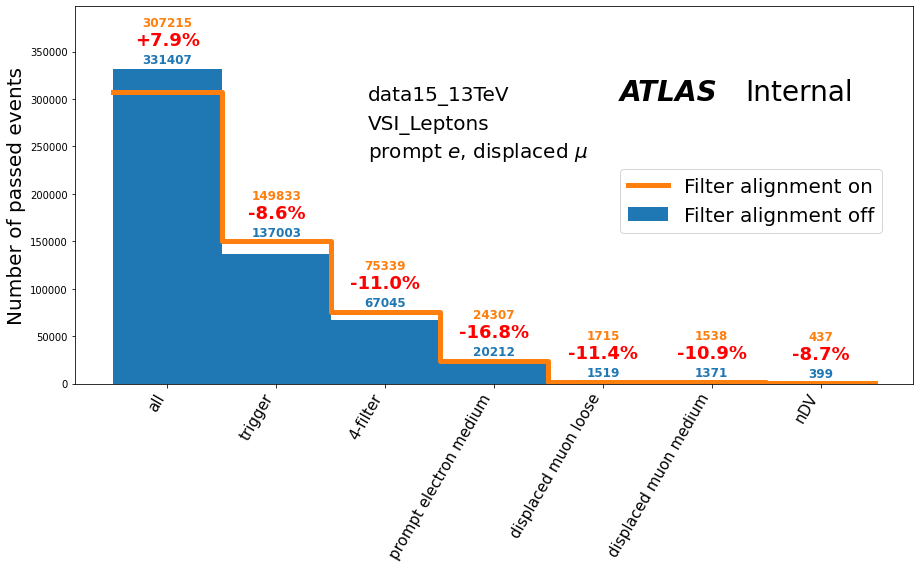

Info in <TCanvas::Print>: png file /data/hnl/data_rep_ntuples/alignment_off/user.rnewhous.data15_13TeV.00284427.physics_Main.merge.DAOD_RPVLL.r11761_r11764_p4054_HNLNtuple_01_tree.root/histograms/plots/Cutflow_alignment_off.png has been created
Info in <TCanvas::Print>: png file /data/hnl/data_rep_ntuples/alignment_off/user.rnewhous.data15_13TeV.00284427.physics_Main.merge.DAOD_RPVLL.r11761_r11764_p4054_HNLNtuple_01_tree.root/histograms/plots/Cutflow_alignment_on.png has been created
Info in <TCanvas::Print>: png file /data/hnl/data_rep_ntuples/alignment_off/user.rnewhous.data15_13TeV.00284427.physics_Main.merge.DAOD_RPVLL.r11761_r11764_p4054_HNLNtuple_01_tree.root/histograms/plots/Cutflow_alignment_off.png has been created
Info in <TCanvas::Print>: png file /data/hnl/data_rep_ntuples/alignment_off/user.rnewhous.data15_13TeV.00284427.physics_Main.merge.DAOD_RPVLL.r11761_r11764_p4054_HNLNtuple_01_tree.root/histograms/plots/Cutflow_alignment_on.png has been created
Info in <TCanvas::Prin

In [302]:
hist_channels = [
    ('histograms_mc_alignment_eu_merged_loose.root', 'prompt $e$, displaced $\mu$'),
    ('histograms_mc_alignment_ue_merged_loose.root', 'prompt $\mu$, displaced $e$'),
    ('histograms_mc_alignment_ee_merged_loose.root', 'prompt $e$, displaced $e$'),
    ('histograms_mc_alignment_ue_merged_medium.root', 'prompt $\mu$, displaced $e$'),
    ('histograms_mc_alignment_ee_merged_medium.root', 'prompt $e$, displaced $e$'),
    ('histograms_mc_alignment_uu_merged_loose.root', 'prompt $\mu$, displaced $\mu$'),
    ('histograms_mc_alignment_uu_merged_medium.root', 'prompt $\mu$, displaced $\mu$'),
    ('histograms_mc_alignment_eu_merged_medium.root', 'prompt $e$, displaced $\mu$'),
]
alignment_off_dir = '/data/hnl/data_rep_ntuples/alignment_off/user.rnewhous.data15_13TeV.00284427.physics_Main.merge.DAOD_RPVLL.r11761_r11764_p4054_HNLNtuple_01_tree.root/histograms/'
alignment_on_dir = '/data/hnl/data_rep_ntuples/alignment_on/user.rnewhous.data15_13TeV.00284427.physics_Main.merge.DAOD_RPVLL.r11969_r11784_p4072_HNLNtuple_01_tree.root/histograms/'

for hist_channel, extra_label in hist_channels:
    path_a = alignment_off_dir + hist_channel
    path_b = alignment_on_dir + hist_channel
    make_cutflows(path_a, path_b, 'VSI', [extra_label])
    make_cutflows(path_a, path_b, 'VSI_Leptons', [extra_label])